# <a id='toc1_'></a>[Content Based Filtering](#toc0_)

This notebook looks at what content based filtering is and how we can apply it to build a recommender system in Python. We start by detailing what content based filtering is. We also look at the advantages adn disadvantages of the method. We also compare this approach with the other popular recommender system method - collaborative filtering. 

> content-based recommendation systems work by suggesting items to users based on what they have liked in the past

**Table of contents**<a id='toc0_'></a>    
- [Overview](#toc2_)    
  - [Disadvantages](#toc2_1_)    
  - [Versus Collaborative Filtering](#toc2_2_)    
- [Data](#toc3_)    
- [Exploration of Data](#toc4_)    
- [A Simple Recommender System](#toc5_)    
  - [Example (Popularity Recommender)](#toc5_1_)    
- [Content Based Recommender System](#toc6_)    
  - [Plot Description Based Recommender](#toc6_1_)    
  - [Credits, Genres, and Keywords Based Recommender](#toc6_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


# <a id='toc2_'></a>[Overview](#toc0_)

Content-based recommendation systems are algorithms that **recommend items to users based on their past interactions with items**, such as viewing history, purchasing history, or rating history. These systems **use the content or attributes of items**, such as genre, director, actor, or tags, to recommend items that are similar to those the user has previously interacted with.

Another way of thinking about content based systems: the system uses item **metadata** (attributes) such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person likes a particular item, he or she will also like an item that is similar to it. And to recommend that, it will make use of the user's past item metadata. 
- A good example could be YouTube, where based on your history, it suggests you new videos that you could potentially watch.


## <a id='toc2_1_'></a>[Disadvantages](#toc0_)

- They can suffer from limited diversity in recommendations, as they only consider the items that the user has interacted with in the past.
- They may not be able to recommend items that are outside of the user's normal preferences.
- Suffer from *cold start problem*

> Note, that to alleviate cold start problem we can employ **Active learning**. This technique is used in recommendation systems to address the "cold-start" problem, where there is little to no data available about a new user's preferences. The basic idea behind active learning is to interact with the user and **collect their preferences or feedback** to build a better model of their interests.

## <a id='toc2_2_'></a>[Versus Collaborative Filtering](#toc0_)

Content-based recommendation systems are different from collaborative filtering systems, which make recommendations based on the past behavior of similar users. In contrast, content-based systems only consider the user's individual preferences, not the preferences of other users.


# <a id='toc3_'></a>[Data](#toc0_)

The dataset files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. This dataset captures feature points like cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, IMDb vote counts, and vote averages. Note we are dealing with a subset of the data. 

- The Full MovieLens Dataset comprises of 26 million ratings and 750,000 tag applications, from 270,000 users on all the 45,000 movies in this dataset. It can be accessed from the official [GroupLens](https://grouplens.org/datasets/movielens/latest/) website.

In [5]:
# get modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.style as style
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline

In [6]:
# Load Movies Metadata
metadata = pd.read_csv('Data/Movies Metadata/movies_metadata.csv', low_memory=False)

# Keep specific columns
metadata = metadata[['id','original_title', 'production_companies', 'genres', 'runtime', 'vote_average', 'vote_count', 'original_language','overview']]
metadata = metadata[metadata.original_language == 'en'].drop(['original_language'], axis=1)

# Print the first 5 rows
display(metadata.head(5))
print("Shape of Data:", metadata.shape)

,id,original_title,production_companies,genres,runtime,vote_average,vote_count,overview
0,862,Toy Story,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",81.0,7.7,5415.0,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",104.0,6.9,2413.0,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",101.0,6.5,92.0,A family wedding reignites the ancient feud be...
3,31357,Waiting to Exhale,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",127.0,6.1,34.0,"Cheated on, mistreated and stepped on, the wom..."
4,11862,Father of the Bride Part II,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'id': 35, 'name': 'Comedy'}]",106.0,5.7,173.0,Just when George Banks has recovered from his ...


Shape of Data: (32269, 8)


# <a id='toc4_'></a>[Exploration of Data](#toc0_)

Specifically what we shall look at is the top rated movies, movies with most votes and best movies in each genre or by each production company.

In [7]:
metadata[['vote_average', 'vote_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
vote_average,32267.0,5.491171,1.941068,0.0,5.0,5.9,6.7,10.0
vote_count,32267.0,141.566430,574.585080,0.0,3.0,10.0,43.0,14075.0


In [8]:
# Which data has NA for specific columns
metadata[metadata.vote_average.isna()]

# Remove this data
metadata = metadata.drop(metadata[metadata.vote_average.isna()].index)

# reset index
metadata = metadata.reset_index(drop=True)

In [9]:
# ranked top to bottom rated movies
metadata.sort_values(['vote_average'], ascending=False)


# top movies with over 5000 votes
metadata[metadata.vote_count>5000].sort_values(['vote_average'], ascending=False)

,id,original_title,production_companies,genres,runtime,vote_average,vote_count,overview
280,278,The Shawshank Redemption,"[{'name': 'Castle Rock Entertainment', 'id': 9...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",142.0,8.5,8358.0,Framed in the 1940s for the double murder of h...
734,238,The Godfather,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",175.0,8.5,6024.0,"Spanning the years 1945 to 1955, a chronicle o..."
2552,550,Fight Club,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'id': 18, 'name': 'Drama'}]",139.0,8.3,9678.0,A ticking-time-bomb insomniac and a slippery s...
265,680,Pulp Fiction,"[{'name': 'Miramax Films', 'id': 14}, {'name':...","[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",154.0,8.3,8670.0,"A burger-loving hit man, his philosophical par..."
10253,155,The Dark Knight,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...","[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",152.0,8.3,12269.0,Batman raises the stakes in his war on crime. ...
...,...,...,...,...,...,...,...,...
13488,1865,Pirates of the Caribbean: On Stranger Tides,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",136.0,6.4,5068.0,Captain Jack Sparrow crosses paths with a woma...
17967,240832,Lucy,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",89.0,6.3,6048.0,"A woman, accidentally caught in a dark deal, t..."
14795,70981,Prometheus,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",124.0,6.3,5152.0,A team of explorers discover a clue to the ori...
23146,297761,Suicide Squad,"[{'name': 'DC Comics', 'id': 429}, {'name': 'D...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",123.0,5.9,7717.0,"From DC Comics comes the Suicide Squad, an ant..."


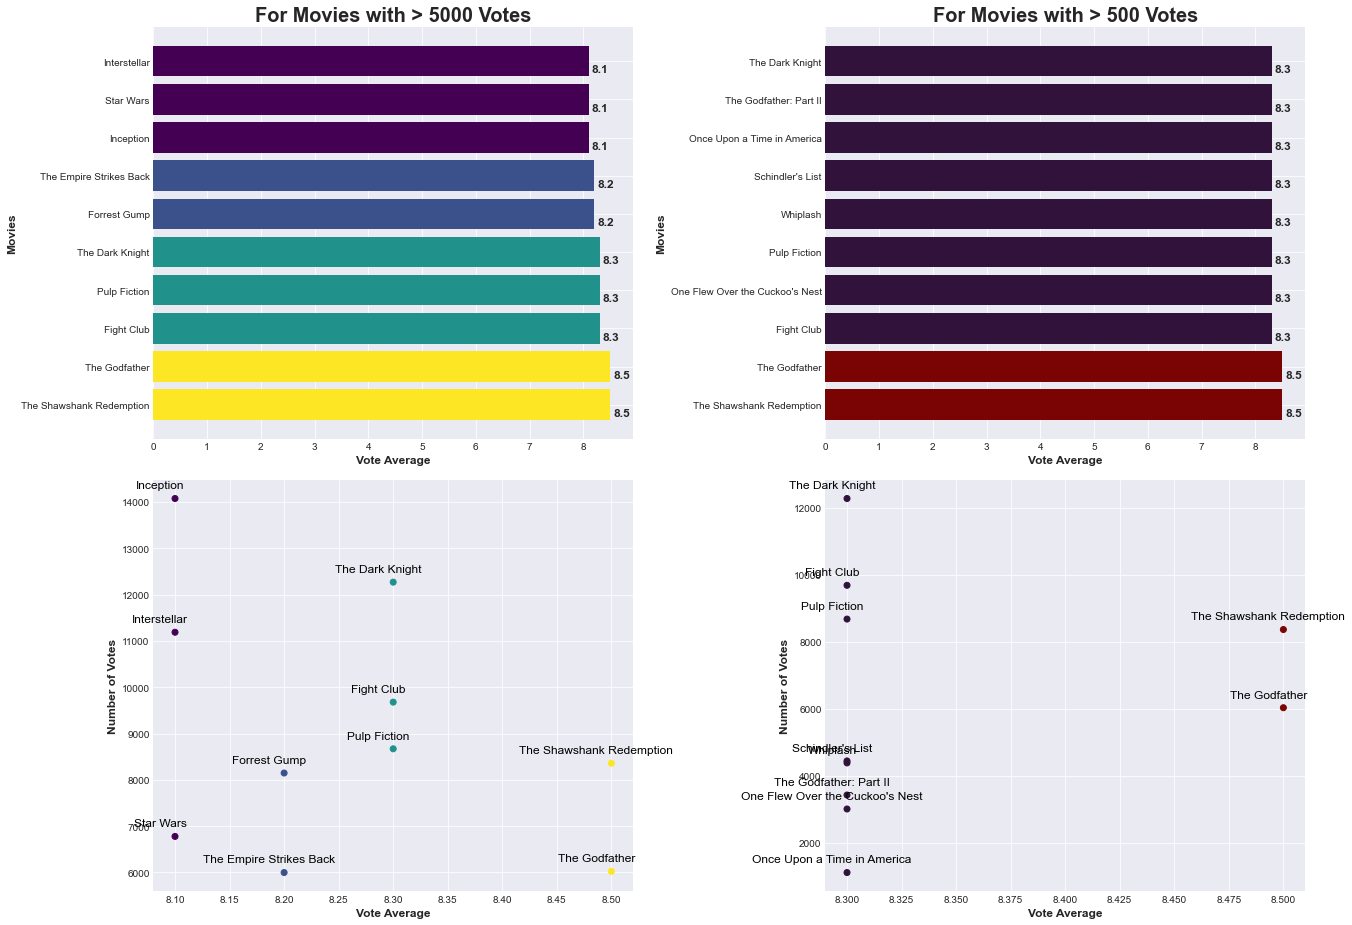

In [10]:
# Horizontal Bar Charts (Top Rated Movies)
sample2 = metadata[metadata.vote_count>=500] \
    .sort_values(['vote_average'], ascending=False) \
    .head(10)
sample4 = metadata[metadata.vote_count>=5000] \
    .sort_values(['vote_average'], ascending=False) \
    .head(10)

# Use a stylesheet
style.use('seaborn-darkgrid')


# color scheme for Sample 4
vote_min = sample4.vote_average.min() # get range of votes
vote_max = sample4.vote_average.max()
vote_norm = (sample4.vote_average - vote_min) / (vote_max - vote_min) # Normalize 
colors = cm.viridis(vote_norm) # Use a colormap to map vote average

# color scheme for Sample 2
vote_min = sample2.vote_average.min() # get range of votes
vote_max = sample2.vote_average.max()
vote_norm = (sample2.vote_average - vote_min) / (vote_max - vote_min) # Normalize 
colors2 = cm.turbo(vote_norm) # Use a colormap to map vote average

# create figure
fig = plt.figure(figsize=(20, 15))


# Plot the bar plot -- 1
plt.subplot(2, 2, 1)
bar = plt.barh(y=sample4.original_title, width=sample4.vote_average, color=colors)
plt.title("For Movies with > 5000 Votes", fontsize=20, fontweight='bold')
plt.xlabel("Vote Average", fontsize=12, fontweight='semibold')
plt.ylabel("Movies", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 7), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)


# Plot the scatter plot -- 2
plt.subplot(2, 2, 3)
plt.scatter(sample4.vote_average, sample4.vote_count, c=colors, cmap='viridis')
plt.xlabel('Vote Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Votes', fontsize=12, fontweight='semibold')
for i, title in enumerate(sample4.original_title):
    plt.annotate(title, (sample4.loc[sample4.original_title==title, "vote_average"], sample4.loc[sample4.original_title==title, "vote_count"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')

# Plot the bar plot -- 3
plt.subplot(2, 2, 2)
bar = plt.barh(y=sample2.original_title, width=sample2.vote_average, color=colors2)
plt.title("For Movies with > 500 Votes", fontsize=20, fontweight='bold')
plt.xlabel("Vote Average", fontsize=12, fontweight='semibold')
plt.ylabel("Movies", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 7), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)

# Plot the bar plot -- 4
plt.subplot(2, 2, 4)
plt.scatter(sample2.vote_average, sample2.vote_count, c=colors2, cmap='autumn')
plt.xlabel('Vote Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Votes', fontsize=12, fontweight='semibold')
for i, title in enumerate(sample2.original_title):
    plt.annotate(title, (sample2.loc[sample2.original_title==title, "vote_average"], sample2.loc[sample2.original_title==title, "vote_count"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')


fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.1)


In [11]:
# extracting genre and production of movies - regex
import re

# extract ALL genres
# for i in range(len(metadata)):
#     match = re.findall("'name': '([^']+)'", metadata.genres[i])
#     metadata.genres[i] = match

# extract one genres
for i in range(len(metadata)):
    match = re.search("'name': '([^']+)'", metadata.genres[i])
    if match:
        metadata.genres[i] = match.group(1)

# extract production companies
for i in range(len(metadata)):
    match = re.search("'name': '([^']+)'", metadata.production_companies[i])
    if match:
        metadata.production_companies[i] = match.group(1)

# see result 
metadata.head(15)

# clean 
metadata = metadata[(metadata.genres!="[]") & (metadata.production_companies!="[]")]

# save data frame
metadata.to_csv("/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Movies Metadata/metadata_cleaned.csv", index=False);

/var/folders/y5/7wlh6jzj03185p7x7ggqb_280000gn/T/ipykernel_68726/3337000329.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.genres[i] = match.group(1)
/var/folders/y5/7wlh6jzj03185p7x7ggqb_280000gn/T/ipykernel_68726/3337000329.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.production_companies[i] = match.group(1)


` re.search` looks for the first occurrence of a string that matches the pattern `"'name': '([^']+)'"`. The pattern uses a regular expression group `([^']+)` to match one or more characters that are not a single quote (\`).

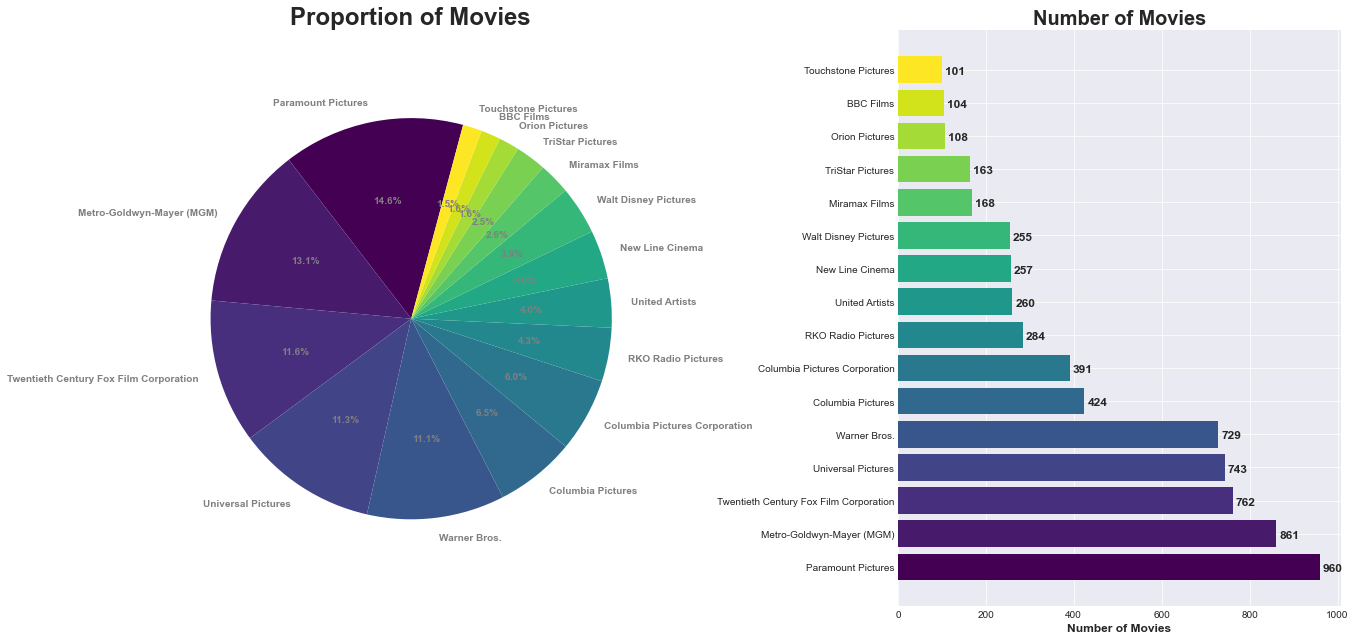

In [12]:
# load cleaned data
metadata = pd.read_csv("Data/Movies Metadata/metadata_cleaned.csv")

# biggest companies (most movies) - over 100 movies
big_comps = metadata
value_counts_prod = big_comps.production_companies.value_counts()
small_comps = value_counts_prod[value_counts_prod < 100].index
big_comps.loc[big_comps.production_companies.isin(small_comps), 'production_companies'] = 'Other'
big_comps = big_comps[big_comps.production_companies != 'Other']
value_counts_prod = big_comps.production_companies.value_counts()
value_counts_prod
colors = cm.viridis(np.linspace(0, 1, len(value_counts_prod)))

# Production Companies mix - pie
fig = plt.figure(figsize=(20, 10)) # create figure
plt.subplot(1, 2, 1)
plt.pie(value_counts_prod, labels=value_counts_prod.index, 
       autopct='%.1f%%', startangle=75, colors=colors, textprops={'color':'grey', 'weight':'bold'})
plt.title("Proportion of Movies", fontsize=24, fontweight='bold')
plt.axis('equal')


# Production Companies with most movies - bar
plt.subplot(1, 2, 2)
bar = plt.barh(y=value_counts_prod.index, width=value_counts_prod.values, color=colors)
plt.title("Number of Movies", fontsize=20, fontweight='bold')
plt.xlabel("Number of Movies", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 12), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)

# adjust plot
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.6, hspace=0.1)


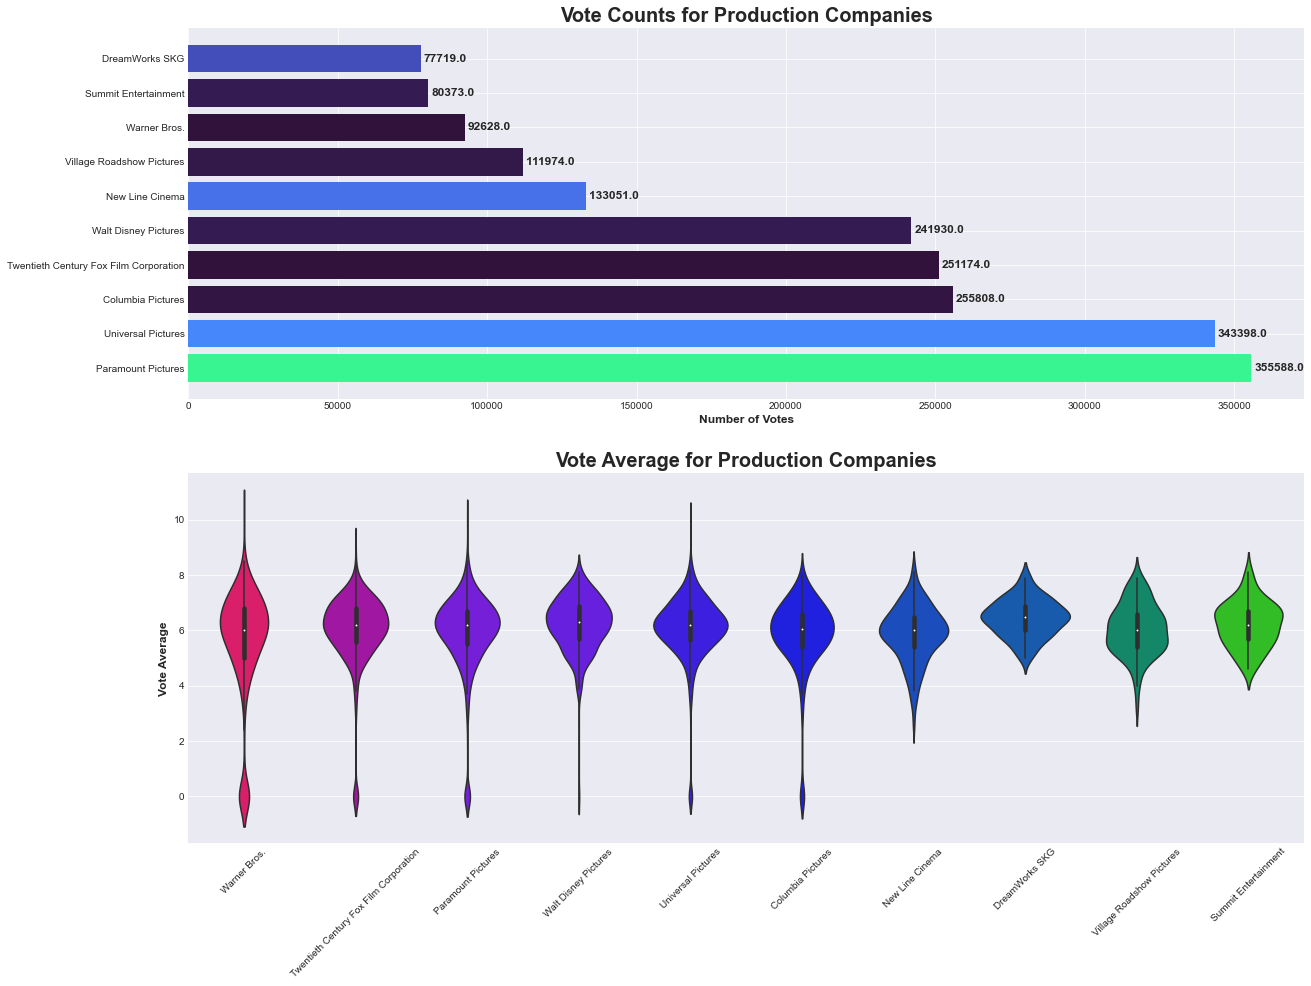

In [13]:
metadata = pd.read_csv("Data/Movies Metadata/metadata_cleaned.csv")
metadata = metadata[(metadata.genres!="[]") & (metadata.production_companies!="[]")]

votes_comps = metadata[["production_companies", "vote_average", "vote_count"]]

plt.style.use('seaborn-darkgrid')

# Production Companies with most votes - bar
votes_count_prod = votes_comps.groupby(by="production_companies")
votes_count_prod = votes_count_prod.sum().sort_values(["vote_count"], ascending=False).head(10)
votes_count_prod = votes_count_prod[['vote_count']]


vote_min = votes_comps.vote_count.min() # get range of votes
vote_max = votes_comps.vote_count.max()
vote_norm = (votes_comps.vote_count - vote_min) / (vote_max - vote_min) # Normalize 
colors = cm.turbo(vote_norm) # Use a colormap to map vote average

fig = plt.figure(figsize=(20, 15))

plt.subplot(2, 1, 1)
bar = plt.barh(y=votes_count_prod.index, width=votes_count_prod.vote_count, color=colors)
plt.title("Vote Counts for Production Companies", fontsize=20, fontweight='bold')
plt.xlabel("Number of Votes", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 14), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)


# Same Production Companies with average votes - violin
plt.subplot(2, 1, 2)
data = votes_comps[votes_comps.production_companies.isin(votes_count_prod.index)][['production_companies', 'vote_average']]
sns.violinplot(x="production_companies", y="vote_average", data=data, palette='prism')
plt.xlabel("", fontsize=12, fontweight='semibold')
plt.ylabel("Vote Average", fontsize=12, fontweight='semibold')
plt.title("")
plt.title("Vote Average for Production Companies", fontsize=20, fontweight='bold')
plt.xticks(rotation=45);

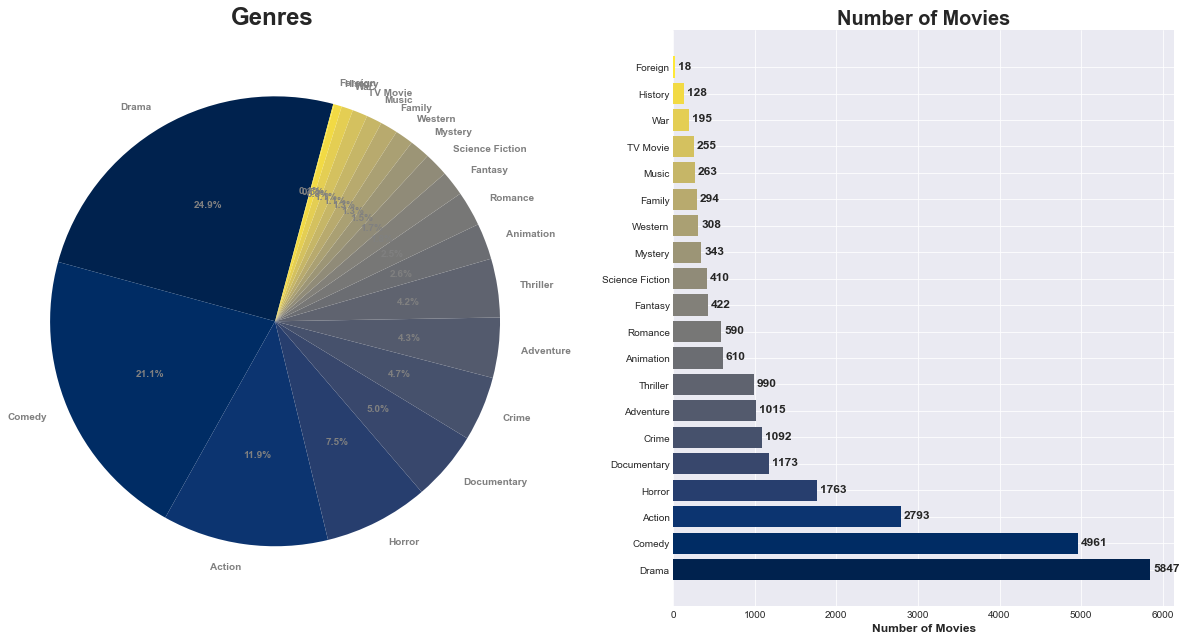

In [14]:
# load data
metadata = pd.read_csv("Data/Movies Metadata/metadata_cleaned.csv")
metadata = metadata[(metadata.genres!="[]") & (metadata.production_companies!="[]")]

# Genres (with a lot of movies)
genre_mix = metadata
value_counts_genre = genre_mix.genres.value_counts()
small_genres = value_counts_genre[value_counts_genre < 10].index
genre_mix.loc[genre_mix.genres.isin(small_genres), 'genres'] = 'Other'
genre_mix = genre_mix[genre_mix.genres != 'Other']
value_counts_genre = genre_mix.genres.value_counts()
value_counts_genre
colors = cm.cividis(np.linspace(0, 1, len(value_counts_genre)))

# Production Companies mix - pie
fig = plt.figure(figsize=(20, 10)) # create figure
plt.subplot(1, 2, 1)
plt.pie(value_counts_genre, labels=value_counts_genre.index, 
       autopct='%.1f%%', startangle=75, colors=colors, textprops={'color':'grey', 'weight':'bold'})
plt.title("Genres", fontsize=24, fontweight='bold')
plt.axis('equal')


# Production Companies with most movies - bar
plt.subplot(1, 2, 2)
bar = plt.barh(y=value_counts_genre.index, width=value_counts_genre.values, color=colors)
plt.title("Number of Movies", fontsize=20, fontweight='bold')
plt.xlabel("Number of Movies", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 12), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)

# adjust plot
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.1)


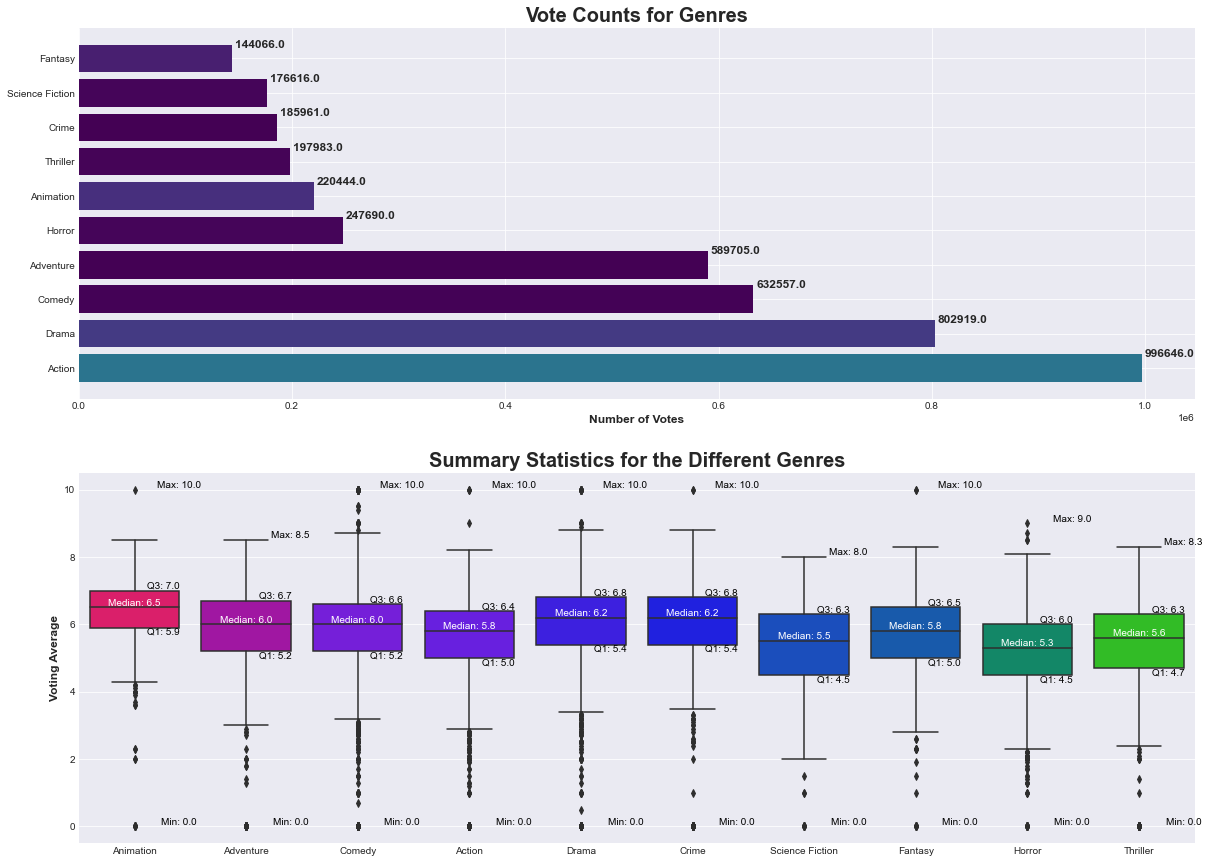

In [15]:
# load data
metadata = pd.read_csv("Data/Movies Metadata/metadata_cleaned.csv")
metadata = metadata[(metadata.genres!="[]") & (metadata.production_companies!="[]")]

# Genres - most popular 
votes_genres = metadata[["genres", "vote_average", "vote_count"]]

# Genres with most movies - bar
votes_count_genres = votes_genres.groupby(by="genres")
votes_count_genres = votes_count_genres.sum().sort_values(["vote_count"], ascending=False).head(10)
votes_count_genres = votes_count_genres[['vote_count']]

vote_min = votes_genres.vote_count.min() # get range of votes
vote_max = votes_genres.vote_count.max()
vote_norm = (votes_genres.vote_count - vote_min) / (vote_max - vote_min) # Normalize 
colors = cm.viridis(vote_norm) # Use a colormap to map vote average

fig = plt.figure(figsize=(20, 15))

plt.subplot(2, 1, 1)
bar = plt.barh(y=votes_count_genres.index, width=votes_count_genres.vote_count, color=colors)
plt.title("Vote Counts for Genres", fontsize=20, fontweight='bold')
plt.xlabel("Number of Votes", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 28), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)


# Genres wih average votes - box plot
plt.subplot(2, 1, 2)
data = votes_genres[votes_genres.genres.isin(votes_count_genres.index)][['genres', 'vote_average']]
sns.boxplot(x="genres", y="vote_average", data=data, palette='prism')
plt.title("Summary Statistics for the Different Genres", fontsize=20, fontweight='bold')
plt.xlabel("", fontsize=20, fontweight='bold')
plt.ylabel("Voting Average", fontsize=12, fontweight='bold')

for i in data['genres'].unique():
    stats = data[data['genres'] == i]['vote_average']
    median = stats.median()
    quartile_1 = stats.quantile(0.25)
    quartile_3 = stats.quantile(0.75)
    max_value = stats.max()
    min_value = stats.min()
    
    plt.text(data['genres'].unique().tolist().index(i)+.40, max_value, 'Max: {:.1f}'.format(max_value), ha = 'center', color = 'black', va='bottom')
    plt.text(data['genres'].unique().tolist().index(i)+0.26, quartile_3, 'Q3: {:.1f}'.format(quartile_3), ha = 'center', color = 'black', va='bottom')
    plt.text(data['genres'].unique().tolist().index(i), median, 'Median: {:.1f}'.format(median), ha = 'center', color = 'white', va='bottom')
    plt.text(data['genres'].unique().tolist().index(i)+0.26, quartile_1, 'Q1: {:.1f}'.format(quartile_1), ha = 'center', color = 'black', va='top')
    plt.text(data['genres'].unique().tolist().index(i)+.40, min_value, 'Min: {:.1f}'.format(min_value), ha = 'center', color = 'black', va='bottom')

Key Features we can identify:

- Animation has in general, a greater proportion of movies who have higher ratings than other genres
- Crime and Drama genre have very similar distribution of vote averages for their movies.
- Horror, has the lowest median vote average. 
- Certain genres don't have any movies which are rated above 9, for example, science-fiction, thriller and adventure genres. 
- We have several genres with movies that have 10 ratings and 0 ratings. ALthough these are outliers, they most likely have very few votes. 
- Science Fiction genre has the greatest spread of average ratings.

# <a id='toc5_'></a>[A Simple Recommender System](#toc0_)

These type of recommenders have no intrinsic algorithm that generates personalized recommendations. Instead it offers generalized recommendations to every user, based on movie popularity and/or genre. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience. 


## <a id='toc5_1_'></a>[Example (Popularity Recommender System)](#toc0_)

We want to clone the IMDb top 250 and use it as a simple recommendation to users. 

The following are the steps involved:

1. Decide on the metric or score to rate movies on.
2. Calculate the score for every movie.
3. Sort the movies based on the score and output the top results.

Note that we are to come up with a weighted rating that takes into account the average rating and the number of votes it has accumulated. Such a system will make sure that a movie with a 9 rating from 100,000 voters gets a (far) higher score than a movie with the same rating but a mere few hundred voters.

Since we are trying to build a clone of IMDB's Top 250, let's use its weighted rating formula as a metric/score. 

Mathematically, it is represented as follows: $\begin{equation} \text{Weighted Rating }(\bf WR) = \left({{\bf v} \over {\bf v} + {\bf m}} \cdot R\right) + \left({{\bf m} \over {\bf v} + {\bf m}} \cdot C\right) \end{equation}$

In the above equation,

- $v$ is the number of votes for the movie;

- $m$ is the minimum votes required to be listed in the chart;

- $R$ is the average rating of the movie;

- $C$ is the mean vote across the whole report.
 
 We already have $v$ (**vote_count**) and $R$ (**vote_average**) in the data set for each movie. Determining an appropriate value for $m$ is a hyperparameter that you can choose accordingly since there is no right value for $m$. We shall use cuttoff $m$ as the 90th percentile. In other words, for a movie to be featured in the charts, it must have **more votes** than at least 90% of the movies on the list. *Note, as percentile decreases, the number of movies considered will increase*. 

In [16]:
# load cleaned dataset 
metadata = pd.read_csv("Data/Movies Metadata/metadata_cleaned.csv")
display(metadata.head(10))
print("Shape:", metadata.shape)

,id,original_title,production_companies,genres,runtime,vote_average,vote_count,overview
0,862,Toy Story,Pixar Animation Studios,Animation,81.0,7.7,5415.0,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,TriStar Pictures,Adventure,104.0,6.9,2413.0,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,Warner Bros.,Romance,101.0,6.5,92.0,A family wedding reignites the ancient feud be...
3,31357,Waiting to Exhale,Twentieth Century Fox Film Corporation,Comedy,127.0,6.1,34.0,"Cheated on, mistreated and stepped on, the wom..."
4,11862,Father of the Bride Part II,Sandollar Productions,Comedy,106.0,5.7,173.0,Just when George Banks has recovered from his ...
5,949,Heat,Regency Enterprises,Action,170.0,7.7,1886.0,"Obsessive master thief, Neil McCauley leads a ..."
6,11860,Sabrina,Paramount Pictures,Comedy,127.0,6.2,141.0,An ugly duckling having undergone a remarkable...
7,45325,Tom and Huck,Walt Disney Pictures,Action,97.0,5.4,45.0,"A mischievous young boy, Tom Sawyer, witnesses..."
8,9091,Sudden Death,Universal Pictures,Action,106.0,5.5,174.0,International action superstar Jean Claude Van...
9,710,GoldenEye,United Artists,Adventure,130.0,6.6,1194.0,James Bond must unmask the mysterious head of ...


Shape: (23470, 8)


In [17]:
# Calculate C (mean votes)
C = metadata['vote_average'].mean()
print(C)

5.686685129953196


The average rating of a movie on IMDb is around 5.7 on a scale of 10.

In [18]:
# Calculate the minimum number of votes required to be in the chart, m
m = metadata['vote_count'].quantile(0.90)
print(m)

387.0


Use the `.copy()` method to ensure that the new `q_movies` DataFrame created is independent of your original metadata DataFrame. In other words, any changes made to the `q_movies` DataFrame will not affect the original metadata data frame.

In [19]:
# Filter out all qualified movies into a new DataFrame
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
print("Shape of Movies with more than 387 Movies:", q_movies.shape)
print("Shape of all movies:", metadata.shape)

Shape of Movies with more than 387 Movies: (2350, 8)
Shape of all movies: (23470, 8)


Now we calculate the weighted rating for each qualified movie. To do this, you will:

1. Define a function, weighted_rating();
2. Since you already have calculated m and C you will simply pass them as an argument to the function;
3. Then you will select the vote_count(v) and vote_average(R) column from the q_movies data frame;
4. Finally, you will compute the weighted average and return the result.

Define a new feature `score`, of which you'll calculate the value by applying this function to your DataFrame of qualified movies.

In [20]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

Now we sort the DataFrame in descending order based on the score feature column and output the title, vote count, vote average, and weighted rating (score) of the top 20 movies.

In [21]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 20 movies
q_movies[['original_title', 'vote_count', 'vote_average', 'score']].head(20)

,original_title,vote_count,vote_average,score
261,The Shawshank Redemption,8358.0,8.5,8.375500
655,The Godfather,6024.0,8.5,8.330174
8836,The Dark Knight,12269.0,8.3,8.220089
2286,Fight Club,9678.0,8.3,8.199518
247,Pulp Fiction,8670.0,8.3,8.188335
452,Schindler's List,4436.0,8.3,8.090306
14609,Whiplash,4376.0,8.3,8.087665
295,Forrest Gump,8147.0,8.2,8.086026
908,The Empire Strikes Back,5998.0,8.2,8.047666
10536,Inception,14075.0,8.1,8.035420


This is our simple recommender. For users we can simply recommend them the highest score movie, given they have not already watched it. The result is generalized an not personalized to user at all.

# <a id='toc6_'></a>[Content Based Recommender System](#toc0_)

## <a id='toc6_1_'></a>[Plot Description Based Recommender](#toc0_)

    We shall build a system that recommends movies that are similar to a particular movie. 

To achieve this, you will compute **pairwise cosine similarity scores** for all movies based on their **plot descriptions** and recommend movies based on that similarity score threshold.

The plot description is available to you as the overview feature in your metadata dataset.

In [22]:
# see plot overview of some movies
metadata.overview.head(3)

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
Name: overview, dtype: object

We need to extract some kind of features from the above text data before you can compute the similarity and/or dissimilarity between them. To do this, you need to compute the word vectors of each overview or document. Note, word vectors are vectorized representation of words in a document.

We shall compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. THis gives us a matrix where **each row represents a word** in the overview vocabulary (all the words that appear in at least one document), and **each column represents a movie**. 

> the TF-IDF score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs.

This is done to reduce the importance of words that frequently occur in plot overviews and, therefore, their significance in computing the final similarity score.

In [23]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
metadata['overview'] = metadata['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(metadata['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(23470, 46342)

Above, we: 

1. `TfidfVectorizer` class is imported from the `feature_extraction.text` module of the scikit-learn library

2. A Tf-Idf vectorizer object is defined and stop words in the English language are removed

3. The `overview` column of the 'metadata' dataframe is checked for any missing values (NaN), and if any are found, they are replaced with an empty string

4. The Tf-Idf matrix is then constructed by fitting and transforming the `overview` column data using the Tf-Idf vectorizer object 'tfidf'.

5. the shape of the Tf-Idf matrix is outputted
*   the shape indicates the dimensions of the matrix. I.e., the number of documents or movie reviews (rows) and the number of terms or number of words (columns) in the matrix.

Note, the values in the matrix (***tfidf-matrix***) represent the Tf-Idf scores for each term in each document. The Tf-Idf score reflects the importance of a term in a document relative to the importance of that term in the entire corpus.



 

In [24]:
#Array mapping from feature integer indices to feature name.
tfidf.get_feature_names()[5000:5010]

/Users/pavansingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['bog',
 'bogarde',
 'bogart',
 'bogeymen',
 'boggarts',
 'boggling',
 'boggs',
 'bogie',
 'bogolyubov',
 'bogomil']

We return a list of all the unique terms (features) in the TF-IDF matrix, in the order that they appear.

With this matrix in hand, you can now compute a similarity score. There are many similarity measures available. We will be using the **cosine similarity** to calculate a numeric quantity that denotes the similarity between two movies. 

<br>

$$\cos (\mathbf{x}, \mathbf{y})=\frac{\mathbf{x} \cdot \mathbf{y}^{\mathrm{\top}}}{\|\mathbf{x}\| \cdot\|\mathbf{y}\|}=\frac{\sum_{i=1}^n \mathbf{x}_i \cdot \mathbf{y}_i^{\top}}{\sqrt{\sum_{i=1}^n\left(\mathbf{x}_i\right)^2} \sqrt{\sum_{i=1}^n\left(\mathbf{y}_i\right)^2}}$$


***Note that***: The TF-IDF vectors are usually sparse and large in size, and directly calculating the dot product between all pairs of vectors becomes computationally expensive.

The `linear_kernel` is implemented in a way that it calculates the dot product between two matrices efficiently, making it faster for large sparse matrices like the TF-IDF matrix.

The `linear_kernel` function is optimized for calculating dot products between two matrices, so it is faster and more efficient than using the `cosine_similarities` function, especially when dealing with sparse matrices like the TF-IDF matrix.

***Note! Calculating the dot product between each vector will directly give you the cosine similarity score***

- We will get a `23470x23470` matrix which means each movie overview cosine similarity score with every other movie overview. Hence, each movie will be a `1x23470` column vector where each column will be a similarity score with each movie.



In [25]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# get shape
cosine_sim.shape

(23470, 23470)

In [26]:
# lets look at similarity matrix
np.fill_diagonal(cosine_sim,0) # make diagonal elements 0
plot_sim_mat = pd.DataFrame(cosine_sim)
plot_sim_mat.index = metadata.original_title
plot_sim_mat.columns = metadata.original_title
display(plot_sim_mat)

original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Cadet Kelly,Les affiches en goguette,Le locataire diabolique,Pooh's Heffalump Halloween Movie,The Morning After,House of Horrors,The Burkittsville 7,Caged Heat 3000,Robin Hood,Betrayal
original_title,,,,,,,,,,,,,,,,,,,,,
Toy Story,0.000000,0.016336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000
Jumanji,0.016336,0.000000,0.048357,0.000000,0.000000,0.049375,0.000000,0.000000,0.101454,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.011998,0.00000,0.000000
Grumpier Old Men,0.000000,0.048357,0.000000,0.000000,0.024935,0.000000,0.000000,0.006783,0.000000,0.000000,...,0.000000,0.0,0.000000,0.018400,0.000000,0.0,0.00000,0.000000,0.00000,0.000000
Waiting to Exhale,0.000000,0.000000,0.000000,0.000000,0.000000,0.007467,0.000000,0.009451,0.000000,0.000000,...,0.000000,0.0,0.016343,0.000000,0.000000,0.0,0.00000,0.022553,0.00000,0.000000
Father of the Bride Part II,0.000000,0.000000,0.024935,0.000000,0.000000,0.000000,0.032398,0.000000,0.033303,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
House of Horrors,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030957,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000
The Burkittsville 7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.035894,0.0,0.00000,0.000000,0.02714,0.000000
Caged Heat 3000,0.000000,0.011998,0.000000,0.022553,0.000000,0.000000,0.000000,0.015572,0.009680,0.000000,...,0.013656,0.0,0.000000,0.005701,0.000000,0.0,0.00000,0.000000,0.00000,0.030442


In [27]:
# get recommendations using matrix
plot_sim_mat.loc["Toy Story",:].sort_values(ascending=False).head(10)

original_title
Toy Story 3                                     0.521126
Toy Story 2                                     0.460648
Small Fry                                       0.277717
The 40 Year Old Virgin                          0.265970
Andy Hardy's Blonde Trouble                     0.230282
The Champ                                       0.197090
Andy Peters: Exclamation Mark Question Point    0.194475
Rebel Without a Cause                           0.188132
Life Begins for Andy Hardy                      0.175694
Wabash Avenue                                   0.165259
Name: Toy Story, dtype: float64

In [28]:
# generate function 
def plot_based_recommender(title, k, sim_mat):
    rec = sim_mat.loc[title,:].sort_values(ascending=False).head(k)
    return print("The Recommended Movies for", title, "using Plot Similarity are: \n", rec, "\n \n")

# test function
plot_based_recommender('The Godfather', k = 5, sim_mat=plot_sim_mat)

# test 
plot_based_recommender('The Dark Knight Rises', k = 6, sim_mat=plot_sim_mat)

The Recommended Movies for The Godfather using Plot Similarity are: 
 original_title
The Godfather: Part II     0.456928
The Godfather: Part III    0.171258
Blood Ties                 0.158695
Pristupit k Likvidatsii    0.141631
I Am the Law               0.126864
Name: The Godfather, dtype: float64 
 

The Recommended Movies for The Dark Knight Rises using Plot Similarity are: 
 original_title
The Dark Knight                                       0.307438
Batman Forever                                        0.304731
Batman Returns                                        0.277359
Batman: Under the Red Hood                            0.268780
Batman                                                0.260016
Batman Unmasked: The Psychology of the Dark Knight    0.232785
Name: The Dark Knight Rises, dtype: float64 
 



While the  recommender system does a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by your present system. We can overcome this!

- ***this is a weakness for such plot based recommender systems, it does not capture other attributes and generates a non-diverse recommendation***

- Plot based recommenders are a type of content-based recommender system, where the features used for the items being recommended, where the plot summaries. 

## <a id='toc6_2_'></a>[Credits, Genres, Keywords Based Recommender](#toc0_)

In our previous recommender model, we were restricted to only using plot summaries as a basis for the recommendation. The quality of your recommender would be increased with the usage of better metadata and by capturing more of the finer details.

Now we shall explore using more metadata to (hopefully) generate better more diverse recommendations. 

> We will build a recommender system based on the following metadata: the **3 top actors**, the **director**, related 
**genres**, and the **movie plot keywords**

Some of this data is not available in our existing `metadata.csv`. So we will bring in some new data and merge it. 

- `credits.csv`: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object
- `keywords.csv`: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

In [41]:
# Load keywords and credits and metadata
credits = pd.read_csv('Data/Movies Metadata/credits.csv')
keywords = pd.read_csv('Data/Movies Metadata/keywords.csv')
metadata = pd.read_csv('Data/Movies Metadata/movies_metadata.csv', low_memory=False)

# clean metadata
metadata = metadata[metadata.original_language == 'en'].drop(['original_language'], axis=1)
metadata = metadata.drop(metadata[metadata.vote_average.isna()].index)

# Convert IDs to int. Required for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')


# Merge keywords and credits into your main metadata dataframe
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')
print("Shape of Data:", metadata.shape)


Shape of Data: (32934, 26)


In [42]:
# drop some variables not needed
import copy
cbf_data = copy.copy(metadata)
cbf_data = cbf_data[['id', 'original_title', 'production_companies', 'genres', 'cast','keywords', 'crew', 'vote_average']]
cbf_data.head(5)

,id,original_title,production_companies,genres,cast,keywords,crew,vote_average
0,862,Toy Story,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",7.7
1,8844,Jumanji,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",6.9
2,15602,Grumpier Old Men,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",6.5
3,31357,Waiting to Exhale,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'credit_id': '52fe44779251416c91011acb', 'de...",6.1
4,11862,Father of the Bride Part II,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'id': 35, 'name': 'Comedy'}]","[{'cast_id': 1, 'character': 'George Banks', '...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",5.7


From the new features, `cast`, `crew`, and `keywords`, you need to extract the three most important actors, the director and the keywords associated with that movie.

In [43]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'production_companies', 'genres']
for feature in features:
    cbf_data[feature] = cbf_data[feature].apply(literal_eval)

In [44]:
# Extract Director
director_name = pd.Series(index=range(len(cbf_data)), dtype='str')
director_name

# loop over all movies
for i in range(len(cbf_data.crew)):
    # get director name for movie
    for item in cbf_data.crew[i]:
        if item["job"] == "Director":
            director_name[i] = item["name"]

cbf_data['director'] = director_name

In [45]:
# Extract Cast - we need top three actors
cast_names = [[] for i in range(len(cbf_data.cast))]
for i in range(len(cbf_data.cast)):
    # get cast names for movie
    for item in cbf_data.cast[i]:
            if len(item["name"]) > 3:
                cast_names[i].append(item["name"])
                cast_names[i] = cast_names[i][0:3]
            else: 
                cast_names[i].append(item['name'])

cbf_data['actors'] = cast_names

In [46]:
# Extract Production Company
production_comp = pd.Series(index=range(len(cbf_data)), dtype='str')
production_comp

# loop over all movies
for i in range(len(cbf_data.production_companies)):
    # get director name for movie
    for item in cbf_data.production_companies[i]:
        production_comp[i] = item["name"]

cbf_data['company'] = production_comp

In [47]:
# Extract Genres - all genres
genre_names = [[] for i in range(len(cbf_data.genres))]
for i in range(len(cbf_data.genres)):
    # get genre names for movie
    for item in cbf_data.genres[i]:
        genre_names[i].append(item['name'])

cbf_data['genre'] = genre_names

In [48]:
# Extract Keywords - all of them
key_words = [[] for i in range(len(cbf_data.keywords))]
for i in range(len(cbf_data.keywords)):
    # get keywords for movie
    for item in cbf_data.keywords[i]:
        if len(item["name"]) > 3:
            key_words[i].append(item["name"])
            key_words[i] = key_words[i][0:3]
        else: 
            key_words[i].append(item['name'])

cbf_data['key_words'] = key_words

In [49]:
# clean up - remove old columns
cbf_data = cbf_data[['id', 'original_title', 'company','director', 'actors', 'genre', 'key_words']]
cbf_data.head(4)

,id,original_title,company,director,actors,genre,key_words
0,862,Toy Story,Pixar Animation Studios,John Lasseter,"[Tom Hanks, Tim Allen, Don Rickles]","[Animation, Comedy, Family]","[jealousy, toy, boy]"
1,8844,Jumanji,Interscope Communications,Joe Johnston,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[Adventure, Fantasy, Family]","[board game, disappearance, based on children'..."
2,15602,Grumpier Old Men,Lancaster Gate,Howard Deutch,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[Romance, Comedy]","[fishing, best friend, duringcreditsstinger]"
3,31357,Waiting to Exhale,Twentieth Century Fox Film Corporation,Forest Whitaker,"[Whitney Houston, Angela Bassett, Loretta Devine]","[Comedy, Drama, Romance]","[based on novel, interracial relationship, sin..."


Now, we are inclined to convert the names and keyword instances into lowercase and strip all the spaces between them - we conduct some further text pre-processing. The process of converting names and keyword instances into lowercase and stripping spaces between them helps to standardize the text data and reduce noise in the data set, making it easier for text mining algorithms to process and extract meaningful insights from the text data.

In [60]:
import string

# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.translate(str.maketrans('', '', string.punctuation)).replace(" ", "")) for i in x]
    else:
        #Check if director and company exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.translate(str.maketrans('', '', string.punctuation)).replace(" ", ""))
        else:
            return ''

This function named `clean_data` that takes a single argument `x`. The purpose of this function is to **convert strings to lowercase and remove spaces in between the words**.

The function first checks if `x` is a list. If it is, it applies the following operation to each element in the list:

1. Convert the string to lowercase using the `str.lower` method
2. Any punctuation removed using the `translate` method with `str.maketrans`
3. Remove spaces in between the words using the `replace` method

If `x` is not a list, the function checks if it is a string. If it is, it applies the same operations as described above.

If `x` is not a string or a list, the function returns an empty string.

This function can be used to clean up the text data in a dataframe by applying the function to each cell in the desired columns.

In [63]:
# Apply clean_data function to your features.
features = ['actors', 'key_words', 'director', 'genre', 'company']

for feature in features:
    cbf_data[feature] = cbf_data[feature].apply(clean_data)

cbf_data.head(3)

,id,original_title,company,director,actors,genre,key_words
0,862,Toy Story,pixaranimationstudios,johnlasseter,"[tomhanks, timallen, donrickles]","[animation, comedy, family]","[jealousy, toy, boy]"
1,8844,Jumanji,interscopecommunications,joejohnston,"[robinwilliams, jonathanhyde, kirstendunst]","[adventure, fantasy, family]","[boardgame, disappearance, basedonchildrensbook]"
2,15602,Grumpier Old Men,lancastergate,howarddeutch,"[waltermatthau, jacklemmon, annmargret]","[romance, comedy]","[fishing, bestfriend, duringcreditsstinger]"


Now, in the final preprocessing step, we are to create a string that contains all the metadata that you want to feed to your vectorizer (namely actors, director and keywords, production companies and genres).

THe function we create below, `string_joiner`, will simply join all the required columns by a space. This is the final preprocessing step, and the output of this function will be fed into the word vector model.

In [68]:
# function to simply join all the required columns by a space

def string_joiner(x):
    return ' '.join(x['key_words']) + ' ' + ' '.join(x['actors']) + ' ' + x['director'] + ' ' + ' '.join(x['genre']) + ' ' + x['company']

# Create a new feature
cbf_data['joined'] = cbf_data.apply(string_joiner, axis=1)

# see data with new feature
cbf_data.head(3)

,id,original_title,company,director,actors,genre,key_words,joined
0,862,Toy Story,pixaranimationstudios,johnlasseter,"[tomhanks, timallen, donrickles]","[animation, comedy, family]","[jealousy, toy, boy]",jealousy toy boy tomhanks timallen donrickles ...
1,8844,Jumanji,interscopecommunications,joejohnston,"[robinwilliams, jonathanhyde, kirstendunst]","[adventure, fantasy, family]","[boardgame, disappearance, basedonchildrensbook]",boardgame disappearance basedonchildrensbook r...
2,15602,Grumpier Old Men,lancastergate,howarddeutch,"[waltermatthau, jacklemmon, annmargret]","[romance, comedy]","[fishing, bestfriend, duringcreditsstinger]",fishing bestfriend duringcreditsstinger walter...


The next steps are the same as what we did with your ***plot description based recommender***. One key difference is that you use the `CountVectorizer()` instead of **TF-IDF**. 

> we do not want to down-weight the actor/director's presence if he or she has acted or directed in relatively more movies. 

It doesn't make much intuitive sense to down-weight them in this context. The major difference between `CountVectorizer()` and TF-IDF is the inverse document frequency (IDF) component which is present in later and not in the former.

- `CountVectorizer` class from the `sklearn.feature_extraction.text` module, which is a tool for transforming a collection of text documents into a numerical representation.

- The `CountVectorizer` class is an implementation of a bag-of-words model.

In [69]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(cbf_data['joined'])

# shape 
print("Shape of DTM:", count_matrix.shape)

Shape of DTM: (32934, 63316)


An instance of `CountVectorizer` is created with the argument `stop_words='english'`, which specifies that the built-in English stop words (e.g. "a", "an", "the") should be removed from the text. 

Finally, the `fit_transform` method is called on `count` and the `joined` column of the `cbf_data` dataframe. This method fits the `CountVectorizer` to the text data and returns a document-term matrix. The resulting matrix is stored in the `count_matrix` variable.

A **document-term matrix** (DTM) is a matrix representation of a collection of documents (text data). In this matrix, rows represent individual documents and columns represent terms (i.e. words or tokens) in the vocabulary. The cells of the matrix indicate the frequency of each term in each document. This representation is useful for text data analysis and NLP tasks, as it allows for numerical processing and manipulation of the text data. 

> DTM is a is a way of representing text data in a numerical form, so that mathematical and statistical methods can be applied to it.

Note, we have 32 934 movies (documents) and 63 316 words (vocabulary)

Now we will use the `cosine_similarity` to measure the distance between the embeddings.

> cosine similarity is (often) used to determine how similar two documents are based on their word frequency

The cosine similarity between two documents is calculated by finding the cosine of the angle between the two document vectors in the vector space, where each document is represented as a vector of word frequencies. By using cosine similarity on the count matrix, you are essentially comparing the similarity between each pair of documents in the matrix.





In [79]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

# calculate cosine sim and get similarity matrix
cosine_sim_matrix = cosine_similarity(count_matrix, count_matrix)

In [80]:
# lets look at similarity matrix
np.fill_diagonal(cosine_sim_matrix,0) # make diagonal elements 0
np.round(cosine_sim_matrix,4)
cbf_matrix = pd.DataFrame(cosine_sim_matrix)
cbf_matrix.index = cbf_data.original_title
cbf_matrix.columns = cbf_data.original_title
display(cbf_matrix.head(10))

original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Deep Hearts,The Morning After,House of Horrors,Shadow of the Blair Witch,The Burkittsville 7,Caged Heat 3000,Robin Hood,Betrayal,Satana likuyushchiy,Queerama
original_title,,,,,,,,,,,,,,,,,,,,,
Toy Story,0.000000,0.090909,0.095346,0.090909,0.100504,0.000000,0.095346,0.100504,0.000000,0.000000,...,0.0,0.113961,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
Jumanji,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.201008,0.090909,0.090909,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
Grumpier Old Men,0.095346,0.000000,0.000000,0.190693,0.105409,0.000000,0.200000,0.000000,0.000000,0.000000,...,0.0,0.119523,0.000000,0.0,0.0,0.0,0.111803,0.000000,0.0,0.0
Waiting to Exhale,0.090909,0.000000,0.190693,0.000000,0.100504,0.087039,0.190693,0.100504,0.000000,0.000000,...,0.0,0.227921,0.000000,0.0,0.0,0.0,0.213201,0.106600,0.0,0.0
Father of the Bride Part II,0.100504,0.000000,0.105409,0.100504,0.000000,0.000000,0.105409,0.000000,0.000000,0.000000,...,0.0,0.125988,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
Heat,0.000000,0.000000,0.000000,0.087039,0.000000,0.000000,0.000000,0.192450,0.174078,0.174078,...,0.0,0.109109,0.087039,0.0,0.0,0.0,0.204124,0.306186,0.0,0.0
Sabrina,0.095346,0.000000,0.200000,0.190693,0.105409,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.119523,0.000000,0.0,0.0,0.0,0.111803,0.000000,0.0,0.0
Tom and Huck,0.100504,0.201008,0.000000,0.100504,0.000000,0.192450,0.000000,0.000000,0.201008,0.201008,...,0.0,0.125988,0.000000,0.0,0.0,0.0,0.235702,0.235702,0.0,0.0
Sudden Death,0.000000,0.090909,0.000000,0.000000,0.000000,0.174078,0.000000,0.201008,0.000000,0.272727,...,0.0,0.000000,0.090909,0.0,0.0,0.0,0.106600,0.213201,0.0,0.0


In [85]:
# generate function 
def content_based_recommender(title, k, sim_mat):
    rec = sim_mat.loc[title,:].sort_values(ascending=False).head(k)
    return print("\n The Recommended Movies for", title, "using Content Based Filtering are: \n", rec, "\n")

# test function
content_based_recommender('The Godfather', k = 5, sim_mat=cbf_matrix)

# test function
content_based_recommender('The Dark Knight Rises', k = 6, sim_mat=cbf_matrix)


 The Recommended Movies for The Godfather using Content Based Filtering are: 
 original_title
The Godfather: Part III    0.476731
The Godfather: Part II     0.400000
Rege                       0.365148
The Rain People            0.358569
Mitchell                   0.338062
Name: The Godfather, dtype: float64 


 The Recommended Movies for The Dark Knight Rises using Content Based Filtering are: 
 original_title
The Dark Knight      0.833333
Batman Begins        0.609272
The Prestige         0.522233
Rege                 0.500000
Shiner               0.436436
Bullet to Beijing    0.436436
Name: The Dark Knight Rises, dtype: float64 



The results from our Content Based Filtering model making use of the metadata (keywords, genres, actors, directors and production company) are given above. We see that the recommender model is successful in capturing more information due to more metadata and has given you better recommendations.

Comparing the recommendations from this CBF model to that of the plot based summary model, we see a lot more diversity in the recommendations. 